## Réseaux de neurones avec couche d'embedding de Glove 
### paramètres : vocabulaire limité à 20000
###              vecteurs de taille 300

#### import des données et des packages 

In [ ]:
import pandas as pd
import ast
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import numpy as np 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, GlobalAveragePooling1D, Input, Embedding
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization
import os 
import tensorflow as tf 
import keras 



In [4]:
df = pd.read_csv("/home/ensai/imatag/website_categorization_custom/categorization/Datasets/Feature_dataset_2023-02-01_clean_full.csv")
df = df.drop("Unnamed: 0", axis = 1)


def convert_to_list(row):
    return ast.literal_eval(row['tokens'])

df['tokens'] = df.apply(convert_to_list, axis = 1)

data = []
for index,row in df.iterrows():
    data.append({"class":row["main_category"], "tokens":row["tokens"]})

data_tokens = [' '.join(data[i]['tokens']) for i in range(len(data))]

y = [data[i]['class'] for i in range(len(data))]

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

#### création de l'index de mots et de la matrice d'embedding avec glove 

In [5]:

X_train,X_test,Y_train,Y_test=train_test_split(data_tokens,y,test_size=0.20,stratify=y)


In [8]:
path_to_glove_file = os.path.join(os.path.expanduser("~"), "imatag/website_categorization_custom/glove.6B.300d.txt")

#création de l'index du vocabulaire à partir du modèle Glove pour des vecteurs de taille 100
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs



In [9]:
#création du dictionnaire à partir de nos données
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=300)
text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(128)
vectorizer.adapt(text_ds)

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))


In [10]:
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

#Création de la matrice d'embedding
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:

        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 13378 words (6622 misses)


#### création de nos échantillons d'entraînement et de test 

In [11]:
X_train_vect=[]
for element in X_train:
    X_train_vect.append(vectorizer(np.array(element)).numpy())
X_train_vect=np.vstack(X_train_vect)

X_test_vect=[]
for element in X_test:
    X_test_vect.append(vectorizer(np.array(element)).numpy())
X_test_vect=np.vstack(X_test_vect)


Y_train_encode=pd.get_dummies(Y_train)
Y_test_encode=pd.get_dummies(Y_test)


#### Modèle de réseau de neurones 

In [12]:

model=Sequential()
model.add(Embedding(num_tokens,embedding_dim,embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False, mask_zero=True))
model.add(GlobalAveragePooling1D())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=25,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         6000600   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                19264     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 25)                1625      
                                                                 
Total params: 6,021,489
Trainable params: 20,889
Non-trainable params: 6,000,600
_________________________________________

In [13]:

history=model.fit(X_train_vect, Y_train_encode, batch_size=32, epochs=100, validation_data=(X_test_vect, Y_test_encode))


Epoch 1/100
268/268 [==============================] - 4s 12ms/step - loss: 2.8867 - accuracy: 0.2187 - val_loss: 2.5480 - val_accuracy: 0.3596
Epoch 2/100
268/268 [==============================] - 3s 12ms/step - loss: 2.3547 - accuracy: 0.3918 - val_loss: 2.1927 - val_accuracy: 0.4375
Epoch 3/100
268/268 [==============================] - 3s 11ms/step - loss: 2.1057 - accuracy: 0.4468 - val_loss: 2.0293 - val_accuracy: 0.4846
Epoch 4/100
268/268 [==============================] - 3s 12ms/step - loss: 1.9734 - accuracy: 0.4768 - val_loss: 1.9417 - val_accuracy: 0.4879
Epoch 5/100
268/268 [==============================] - 3s 12ms/step - loss: 1.8889 - accuracy: 0.4993 - val_loss: 1.8823 - val_accuracy: 0.5037
Epoch 6/100
268/268 [==============================] - 3s 12ms/step - loss: 1.8291 - accuracy: 0.5139 - val_loss: 1.8500 - val_accuracy: 0.5201
Epoch 7/100
268/268 [==============================] - 3s 12ms/step - loss: 1.7861 - accuracy: 0.5244 - val_loss: 1.8184 - val_accuracy:

In [16]:
loss, accuracy = model.evaluate(X_train_vect, Y_train_encode, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_vect, Y_test_encode, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7484
Testing Accuracy:  0.5639


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


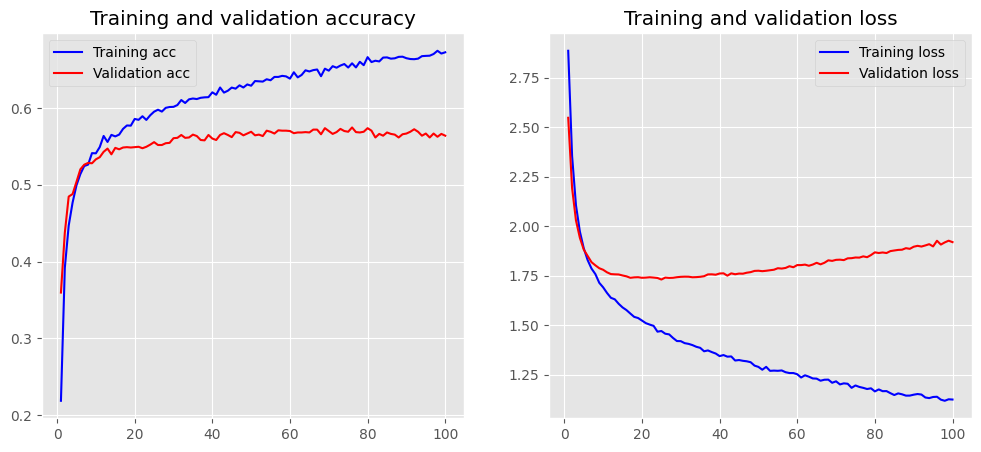

In [14]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    print(history.history.keys())
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy
y_pred=model.predict(x_test)
y_pred_label=np.array([labels.columns[[y_pred[i].argmax()]][0] for i in range(y_test.shape[0])])
y_test_label=np.array([labels.columns[[y_test.iloc[i].argmax()]][0] for i in range(y_test.shape[0])])
confusion_matrix = metrics.confusion_matrix(y_test_label, y_pred_label)

cm_display = metrics.ConfusionMatrixDisplay.from_predictions(y_test_label, y_pred_label,xticks_rotation='vertical')

fig = cm_display.ax_.get_figure() 
fig.set_figwidth(15)
fig.set_figheight(15)  

plt.show() 